In [1]:
import numpy as onp
import jax.numpy as jnp
import matplotlib.pyplot as plt

# from scipy.stats import bernoulli
from jax import random, vmap
from jax.example_libraries import optimizers
from jax import grad, value_and_grad
from jax import jit
from jax.scipy.stats import norm, bernoulli
from os.path import join as pjoin
from jax.random import bernoulli as bernoulli_jax, PRNGKey
from jax.scipy.special import logsumexp
from sklearn.metrics import f1_score
import pandas as pd
import seaborn as sns

from tqdm import tqdm

import matplotlib

font = {"size": 30}
matplotlib.rc("font", **font)
matplotlib.rcParams["text.usetex"] = True


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:

# true_thresholds = [-1.5, 1.5]


def expit(x):
    return 1 / (1 + jnp.exp(-x))


def unpack_variational_params(params):
    means, stddevs = params[:4], jnp.exp(params[4:])
    return means, stddevs


def unpack_model_params(params):
    radius, slope, center = params[0], params[1], params[2:]
    return radius, slope, center


def my_norm(x):
    return jnp.sqrt(jnp.sum(x ** 2, axis=1))


def lognormal_logpdf(x, mean, stddev):
    normalizer = -jnp.log(x) - jnp.log(stddev) - 0.5 * jnp.log(2 * jnp.pi)
    lik = -0.5 * (jnp.log(x) - mean) ** 2 / (stddev ** 2)
    return normalizer + lik


class Model:
    def __init__(self, prior_mean, prior_stddev, key=PRNGKey(4)):
        self.key = key
        self.prior_mean = prior_mean
        self.prior_stddev = prior_stddev

    def predict(self, X, radius, slope, center):
        logits = jnp.linalg.norm(X - center, axis=1) - radius
        logits *= slope
        preds = expit(-logits)
        return preds

    def log_density(self, X, Y, params):
        radius, slope, center = unpack_model_params(params)
        transformed_params = self.predict(X, radius, slope, center)

        log_prior_radius = lognormal_logpdf(
            radius, mean=self.prior_mean, stddev=self.prior_stddev
        )
        log_prior_slope = norm.logpdf(
            slope, loc=self.prior_mean, scale=self.prior_stddev
        )
        log_prior_center1 = norm.logpdf(
            center[0], loc=self.prior_mean, scale=self.prior_stddev
        )
        log_prior_center2 = norm.logpdf(
            center[1], loc=self.prior_mean, scale=self.prior_stddev
        )
        log_prior_center = log_prior_center1 + log_prior_center2

        log_likelihood = jnp.sum(bernoulli.logpmf(k=Y, p=transformed_params))
        return log_likelihood + log_prior_radius + log_prior_slope + log_prior_center


class ApproximateModel:
    def __init__(self, key=PRNGKey(4)):
        self.key = key

    def sample(self, params, size):
        means, stddevs = unpack_variational_params(params)
        std_normal_samples = random.normal(key=self.key, shape=(size, 4))
        samples = std_normal_samples * stddevs + means
        return jnp.hstack([jnp.exp(samples[:, 0]).reshape(-1, 1), samples[:, 1:]])
        return samples

    def log_density(self, responses, params):
        means, stddevs = unpack_variational_params(params)

        radius, slope, center = unpack_model_params(responses)

        log_dens_radius = lognormal_logpdf(radius, mean=means[0], stddev=stddevs[0])
        log_dens_slope = norm.logpdf(slope, loc=means[1], scale=stddevs[1])
        log_dens_center = norm.logpdf(center, loc=means[2:], scale=stddevs[2:]).sum()

        return log_dens_radius + log_dens_slope + log_dens_center


def fit_variational_model(
    X,
    Y,
    model_object,
    n_iters=3000,
    print_every=100,
    n_mcmc_samples_vi=5,
    learning_rate=1e-2,
    verbose=True,
):
    variational_model = ApproximateModel()

    # Initialize variational parameters
    params = jnp.concatenate(
        [
            jnp.ones(4) * 0.5,
            -4 + 1e-4 * random.normal(variational_model.key, shape=(4,)),
        ]
    )

    ## Optimization loop
    opt_init, opt_update, get_params = optimizers.adam(step_size=learning_rate)
    opt_state = opt_init(params)

    VI_objective = lambda params: negative_elbo(
        jnp.array(X),
        jnp.array(Y),
        params,
        model_object,
        variational_model,
        n_mcmc_samples=n_mcmc_samples_vi,
    )

    @jit
    def step(step, opt_state):
        value, grads = value_and_grad(VI_objective)(get_params(opt_state))
        opt_state = opt_update(step, grads, opt_state)
        return value, opt_state

    last_mll = onp.inf
    for step_num in range(int(n_iters)):
        curr_mll, opt_state = step(step_num, opt_state)
        
        if step_num % print_every == 0 and verbose:
            print(
                "Step: {:<15} ELBO: {}".format(
                    step_num, onp.round(-1 * onp.asarray(curr_mll), 2)
                )
            )

    fitted_params = get_params(opt_state)
    return fitted_params


def negative_elbo(X, Y, params, model_object, variational_model, n_mcmc_samples=5):
    # Sample from variational posterior

    curr_samples = variational_model.sample(params, size=n_mcmc_samples)

    # Evaluate model and variational log densities
    model_log_density_eval = jnp.array(
        [model_object.log_density(X, Y, s) for s in curr_samples]
    )

    variational_log_density = jnp.array(
        [variational_model.log_density(s, params) for s in curr_samples]
    )

    # Compute approximate ELBO
    curr_elbo = jnp.mean(model_log_density_eval - variational_log_density)

    return -curr_elbo


@jit
def sample_params(variational_params, n_outer_samples=100, n_inner_samples=50):
    # variational_model = ApproximateModel(key=PRNGKey(4))

    # Sample parameters from current model
    #   (either the prior or posterior conditioned on observed data so far)
    param_samples = variational_model.sample(
        params=variational_params, size=n_inner_samples
    )
    param_samples_for_y = variational_model.sample(
        params=variational_params, size=n_outer_samples
    )
    return param_samples, param_samples_for_y


@jit
def predict_one(x, sample):
    return model.predict(
        X=x.reshape(1, -1), radius=sample[0], slope=sample[1], center=sample[2:]
    )


@jit
def eig_calculation(denominator_loglikelihoods, log_numerator):

    n_inner_samples = denominator_loglikelihoods.shape[1]
    log_denominator_mean = logsumexp(denominator_loglikelihoods, axis=1) - jnp.log(
        n_inner_samples
    )

    eig = jnp.mean(log_numerator - log_denominator_mean)
    return eig


@jit
def sample_bernoulli(p):
    return random.bernoulli(key=variational_model.key, p=p)


@jit
def bernoulli_logpmf(p, x):
    return bernoulli.logpmf(p=p, k=x)


@jit
def nmc(
    design,
    variational_params,
    n_outer_samples=100,
    n_inner_samples=50,
):

    # design = jnp.array(design)

    param_samples, param_samples_for_y = sample_params(variational_params)

    logit_p = vmap(lambda s: vmap(lambda x: predict_one(x.reshape(1, -1), s))(X))(
        param_samples
    ).squeeze(axis=-1)

    logit_p_for_y = vmap(lambda s: vmap(lambda x: predict_one(x.reshape(1, -1), s))(X))(
        param_samples_for_y
    ).squeeze(axis=-1)

    # Sample imaginary data
    y_samples = vmap(lambda p: sample_bernoulli(p=p))(logit_p_for_y).astype(int)

    # Evaluate likelihood of synthetic data
    log_numerator_individual = vmap(lambda lp, y: bernoulli_logpmf(p=lp, x=y))(
        logit_p_for_y, y_samples
    )
    log_numerator_individual = log_numerator_individual * design.reshape(1, -1)
    log_numerator = log_numerator_individual.sum(1)

    denominator_individual_loglikelihoods = vmap(
        lambda y: bernoulli_logpmf(p=logit_p, x=y)
    )(y_samples)

    denominator_individual_loglikelihoods = (
        denominator_individual_loglikelihoods * design.reshape(1, 1, -1)
    )
    denominator_loglikelihoods = jnp.sum(denominator_individual_loglikelihoods, axis=2)

    eig = eig_calculation(denominator_loglikelihoods, log_numerator)
    # import ipdb; ipdb.set_trace()

    return eig


def get_points_near_line(slope, X, intercept=0):
    dists = onp.abs(-slope * X[:, 0] + X[:, 1] - intercept) / onp.sqrt(slope ** 2 + 1)
    observed_idx = onp.where(dists <= slice_radius)[0]
    return observed_idx
    # return dists <= slice_radius


In [3]:
# variational_model = ApproximateModel()
onp.random.seed(1)

prior_mean = 0.0
prior_variance = 1.0



n_experimental_iters = 5
n_repeats = 5
limits = [-3, 3]
grid_size = 50
radius = 1.5
tumor_flip_prob = 0.1
center = onp.array([0, 0])
x1s = onp.linspace(*limits, num=grid_size)
x2s = onp.linspace(*limits, num=grid_size)
X1, X2 = onp.meshgrid(x1s, x2s)
X = onp.vstack([X1.ravel(), X2.ravel()]).T
norms = onp.linalg.norm(X - center, axis=1)
# Y = (norms < radius).astype(int)
X += onp.random.uniform(low=-0.3, high=0.3, size=X.shape)

# Randomly flip some of the tumor cells to be healthy
# tumor_idx = onp.where(Y == 1)[0]
# flip_list = onp.random.binomial(n=1, p=0.9, size=len(tumor_idx))
# Y[tumor_idx] = flip_list

slice_radius = 0.1

# Discretize design space
n_slope_discretizations = 20
n_intercept_discretizations = 20
slope_angles = onp.linspace(0, onp.pi, n_slope_discretizations)
slopes = onp.tan(slope_angles)
intercepts = onp.linspace(limits[0] - 5, limits[1] + 5, n_intercept_discretizations)
designs1, designs2 = onp.meshgrid(intercepts, slopes)
candidate_designs = onp.vstack([designs1.ravel(), designs2.ravel()]).T
n_candidate_designs = len(candidate_designs)


Xs_for_designs = []
for ii, dd in enumerate(candidate_designs):
    curr_idx = get_points_near_line(slope=dd[1], X=X, intercept=dd[0])
    curr_X = X[curr_idx]
    Xs_for_designs.append(curr_X)

    
overall_accuracies = onp.zeros((n_repeats, n_experimental_iters))

for repeat_ii in range(n_repeats):
    
    Y = (norms < radius).astype(int)

    # Randomly flip some of the tumor cells to be healthy
    tumor_idx = onp.where(Y == 1)[0]
    flip_list = onp.random.binomial(n=1, p=1-tumor_flip_prob, size=len(tumor_idx))
    Y[tumor_idx] = flip_list

    model = Model(prior_mean=prior_mean, prior_stddev=onp.sqrt(prior_variance), key=repeat_ii)
    

    observed_idx = []
    best_designs = []
    X_fragment_idx = [onp.arange(len(X))]
    accuracies = []

    for iternum in range(n_experimental_iters):

        assert len(best_designs) == iternum
        assert len(X_fragment_idx) == iternum + 1

        ## Fit variational posterior
        variational_model = ApproximateModel(key=PRNGKey(n_experimental_iters * repeat_ii + iternum))
        print(n_experimental_iters * repeat_ii + iternum)

        if len(observed_idx) == 0:
            fitted_params = jnp.zeros(8) - 1
    #     else:
    #         fitted_params = fit_variational_model(
    #             X=X[onp.unique(onp.array(observed_idx))],
    #             Y=Y[onp.unique(onp.array(observed_idx))],
    #             model_object=model,
    #         )

        # Extract variational parameters
        radius_mean = jnp.exp(fitted_params[0] + 0.5 * jnp.exp(fitted_params[4]) ** 2)
    #     print(radius_mean)
    #     print("Center: ", fitted_params[2:4])

        best_eig = -onp.inf
        best_design_idx, best_fragment_idx, best_observed_idx = None, None, None

        for ff in range(len(X_fragment_idx)):

            # Get data for this fragment
            curr_X = X[X_fragment_idx[ff]]

            eigs = []
            # for dd in tqdm(Xs_for_designs):
            for dd in tqdm(range(len(candidate_designs))):

                # Get points that would be observed by this slice
                curr_design = candidate_designs[dd]

                above_fragment_idx = onp.where(
                    curr_X[:, 1] >= curr_design[0] + curr_X[:, 0] * curr_design[1]
                )[0]
                if len(above_fragment_idx) in [
                    0,
                    1,
                    2,
                    len(curr_X),
                    len(curr_X) - 1,
                    len(curr_X) - 2,
                ]:
                    continue

                curr_observed_idx = get_points_near_line(
                    X=curr_X, slope=curr_design[1], intercept=curr_design[0]
                )
                if len(curr_observed_idx) == 0:
                    continue

                design_mask = onp.zeros(len(X))
                design_mask[curr_observed_idx] = 1

                # Compute EIG of this slice
                curr_eig = nmc(
                    # design=curr_X[curr_observed_idx],
                    design=jnp.array(design_mask),
                    variational_params=fitted_params,
                )

                # Check if this is the best slice yet
                if curr_eig > best_eig:
                    best_design_idx = dd
                    best_fragment_idx = ff
                    best_observed_idx = X_fragment_idx[ff][curr_observed_idx]
                    best_eig = curr_eig

        curr_best_design = candidate_designs[best_design_idx]
        best_fragment_X = X[X_fragment_idx[best_fragment_idx]]

        print("Best EIG: ", best_eig)

        above_fragment_idx = onp.where(
            best_fragment_X[:, 1]
            >= curr_best_design[0] + best_fragment_X[:, 0] * curr_best_design[1]
        )[0]
        below_fragment_idx = onp.where(
            best_fragment_X[:, 1]
            <= curr_best_design[0] + best_fragment_X[:, 0] * curr_best_design[1]
        )[0]

        above_idx = X_fragment_idx[best_fragment_idx][above_fragment_idx]
        below_idx = X_fragment_idx[best_fragment_idx][below_fragment_idx]
        X_fragment_idx.pop(best_fragment_idx)
        X_fragment_idx.append(above_idx)
        X_fragment_idx.append(below_idx)

        best_designs.append(curr_best_design)
        observed_idx.extend(best_observed_idx)

        # Fit model
        fitted_params = fit_variational_model(
            X=X[onp.unique(onp.array(observed_idx))],
            Y=Y[onp.unique(onp.array(observed_idx))],
            model_object=model,
            verbose=False
        )

        ## Extract variational parameters
        radius_estimated = onp.exp(fitted_params[0] + 0.5 * jnp.exp(fitted_params[4]) ** 2)
        slope_estimated = fitted_params[1]
        center_estimated = fitted_params[2:4]
        preds = model.predict(X, radius_estimated, slope_estimated, center_estimated)
        preds_int = (preds > 0.5).astype(int)
    #     accuracy = (preds_int == Y).mean()
        accuracy = f1_score(Y, preds_int)
        accuracies.append(accuracy)

    overall_accuracies[repeat_ii] = accuracies
    
    
# ## Extract variational parameters
# radius_estimated = onp.exp(fitted_params[0] + 0.5 * jnp.exp(fitted_params[4]) ** 2)
# slope_estimated = fitted_params[1]
# center_estimated = fitted_params[2:4]
# preds = model.predict(X, radius_estimated, slope_estimated, center_estimated)


0


100%|██████████| 400/400 [00:06<00:00, 64.30it/s] 


Best EIG:  2.1934235
1


100%|██████████| 400/400 [00:02<00:00, 164.27it/s]


Best EIG:  2.8151672
2


100%|██████████| 400/400 [00:02<00:00, 135.10it/s]


Best EIG:  1.634684
3


100%|██████████| 400/400 [00:02<00:00, 134.38it/s]


Best EIG:  0.95813954
4


100%|██████████| 400/400 [00:02<00:00, 138.04it/s]


Best EIG:  0.8249245
5


100%|██████████| 400/400 [00:04<00:00, 85.62it/s] 


Best EIG:  2.1934235
6


100%|██████████| 400/400 [00:02<00:00, 150.43it/s]


Best EIG:  2.6158278
7


100%|██████████| 400/400 [00:05<00:00, 73.82it/s] 


Best EIG:  1.6947201
8


100%|██████████| 400/400 [00:04<00:00, 87.43it/s] 


Best EIG:  1.5239987
9


100%|██████████| 400/400 [00:03<00:00, 107.36it/s]


Best EIG:  1.0442929
10


100%|██████████| 400/400 [00:05<00:00, 74.90it/s] 


Best EIG:  2.1934235
11


100%|██████████| 400/400 [00:03<00:00, 105.32it/s]


Best EIG:  3.191386
12


100%|██████████| 400/400 [00:03<00:00, 104.18it/s]


Best EIG:  1.5410919
13


100%|██████████| 400/400 [00:04<00:00, 97.33it/s] 


Best EIG:  1.2431215
14


100%|██████████| 400/400 [00:03<00:00, 101.69it/s]


Best EIG:  0.5481005
15


100%|██████████| 400/400 [00:05<00:00, 73.99it/s] 


Best EIG:  2.1934235
16


100%|██████████| 400/400 [00:02<00:00, 135.80it/s]


Best EIG:  2.6158278
17


100%|██████████| 400/400 [00:03<00:00, 117.50it/s]


Best EIG:  1.6276861
18


100%|██████████| 400/400 [00:03<00:00, 106.04it/s]


Best EIG:  1.5672836
19


100%|██████████| 400/400 [00:03<00:00, 107.84it/s]


Best EIG:  1.0684774
20


100%|██████████| 400/400 [00:04<00:00, 82.95it/s] 


Best EIG:  2.1934235
21


100%|██████████| 400/400 [00:02<00:00, 150.01it/s]


Best EIG:  2.6158278
22


100%|██████████| 400/400 [00:03<00:00, 122.71it/s]


Best EIG:  1.6096323
23


100%|██████████| 400/400 [00:03<00:00, 112.47it/s]


Best EIG:  1.5646833
24


100%|██████████| 400/400 [00:03<00:00, 116.21it/s]


Best EIG:  1.0618782


In [4]:
overall_accuracies

array([[0.09756098, 0.73463687, 0.74725275, 0.74897119, 0.73259053],
       [0.09567198, 0.77718833, 0.73333333, 0.78112713, 0.76266667],
       [0.10762332, 0.12803532, 0.1247216 , 0.70301291, 0.78627968],
       [0.09586057, 0.85242031, 0.83080808, 0.80884265, 0.8534279 ],
       [0.09375   , 0.84615385, 0.82689913, 0.80205656, 0.83495146]])

In [5]:
(preds_int == Y).mean()

DeviceArray(0.9456, dtype=float32)

In [6]:
radius_estimated, center_estimated, Y[onp.unique(onp.array(observed_idx))].mean()

(1.3657961,
 DeviceArray([-0.01867849,  0.0223727 ], dtype=float32),
 0.23872679045092837)

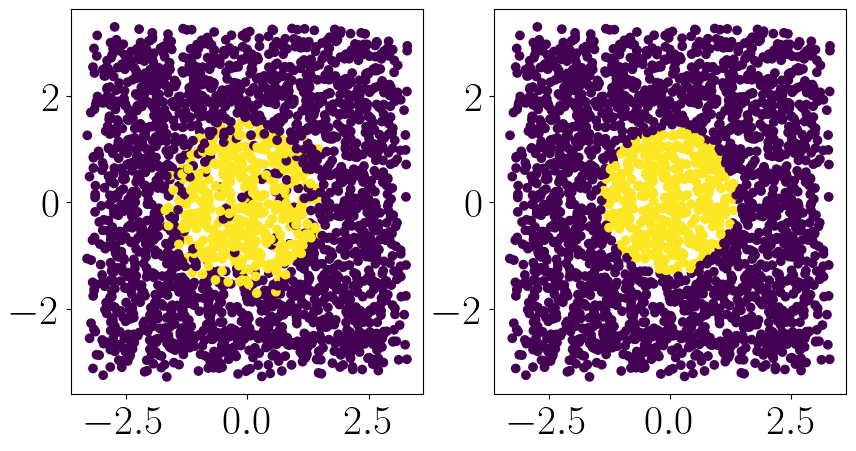

In [7]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.subplot(122)
plt.scatter(X[:, 0], X[:, 1], c=preds_int)
plt.show()

In [8]:

## Compare with serial slicing strategy
intercepts_naive = onp.linspace(limits[0], limits[1], n_experimental_iters + 2)[
    1:-1
]
# intercepts_naive = onp.array([limits[0]])
slopes_naive = onp.zeros(n_experimental_iters)
candidate_designs_naive = onp.stack([intercepts_naive, slopes_naive]).T

overall_accuracies_naive = onp.zeros((n_repeats, n_experimental_iters))

for repeat_ii in range(n_repeats):
    
    Y = (norms < radius).astype(int)

    # Randomly flip some of the tumor cells to be healthy
    tumor_idx = onp.where(Y == 1)[0]
    flip_list = onp.random.binomial(n=1, p=1-tumor_flip_prob, size=len(tumor_idx))
    Y[tumor_idx] = flip_list

    observed_idx_naive = []
    accuracies_naive = []

    for dd in candidate_designs_naive:
        curr_observed_idx = get_points_near_line(X=X, slope=dd[1], intercept=dd[0])
        observed_idx_naive.extend(curr_observed_idx.tolist())

        ## Fit model on data from serial slicing strategy
        fitted_params_naive = fit_variational_model(
            X=X[onp.unique(onp.array(observed_idx_naive))],
            Y=Y[onp.unique(onp.array(observed_idx_naive))],
            model_object=model,
            verbose=False,
        )

        radius_estimated = onp.exp(
            fitted_params_naive[0] + 0.5 * jnp.exp(fitted_params_naive[4]) ** 2
        )
        slope_estimated = fitted_params_naive[1]
        center_estimated = fitted_params[2:4]
        preds_naive = model.predict(X, radius_estimated, slope_estimated, center_estimated)

        # Discretize predictions into tumor/healthy
        preds_naive_int = (preds_naive > 0.5).astype(int)
    #     accuracy_naive = (preds_naive_int == Y).mean()
        accuracy_naive = f1_score(Y, preds_naive_int)
        accuracies_naive.append(accuracy_naive)
        print(accuracy_naive, onp.mean(Y[observed_idx_naive]))

    observed_idx_naive = onp.array(observed_idx_naive)
    
    overall_accuracies_naive[repeat_ii] = accuracies_naive


0.1564482029598309 0.0
0.7142857142857143 0.17901234567901234
0.8765294771968855 0.26406926406926406
0.8769574944071588 0.29375
0.8775510204081632 0.23095823095823095
0.16846652267818574 0.0
0.7603305785123967 0.19753086419753085
0.866442199775533 0.27705627705627706
0.8671789242590561 0.3125
0.8635346756152126 0.2457002457002457
0.16192560175054704 0.0
0.7017543859649121 0.18518518518518517
0.8501170960187354 0.26406926406926406
0.8548571428571429 0.29375
0.8564814814814815 0.23095823095823095
0.1466666666666667 0.0
0.7416666666666666 0.2037037037037037
0.8363201911589009 0.2727272727272727
0.8396226415094339 0.2875
0.8351126927639383 0.22604422604422605
0.1627408993576017 0.0
0.7161198288159771 0.19135802469135801
0.8615384615384615 0.26406926406926406
0.867630700778643 0.303125
0.867117117117117 0.23832923832923833


In [9]:
overall_accuracies_naive

array([[0.1564482 , 0.71428571, 0.87652948, 0.87695749, 0.87755102],
       [0.16846652, 0.76033058, 0.8664422 , 0.86717892, 0.86353468],
       [0.1619256 , 0.70175439, 0.8501171 , 0.85485714, 0.85648148],
       [0.14666667, 0.74166667, 0.83632019, 0.83962264, 0.83511269],
       [0.1627409 , 0.71611983, 0.86153846, 0.8676307 , 0.86711712]])

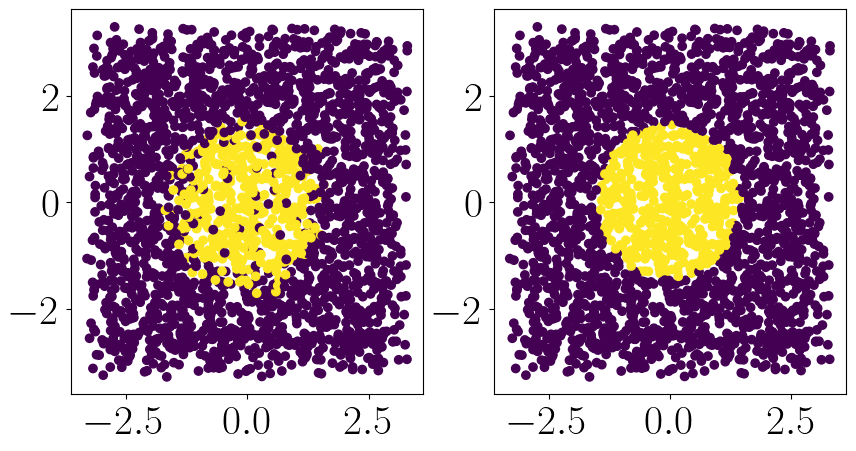

In [10]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.subplot(122)
plt.scatter(X[:, 0], X[:, 1], c=preds_naive_int)
plt.show()

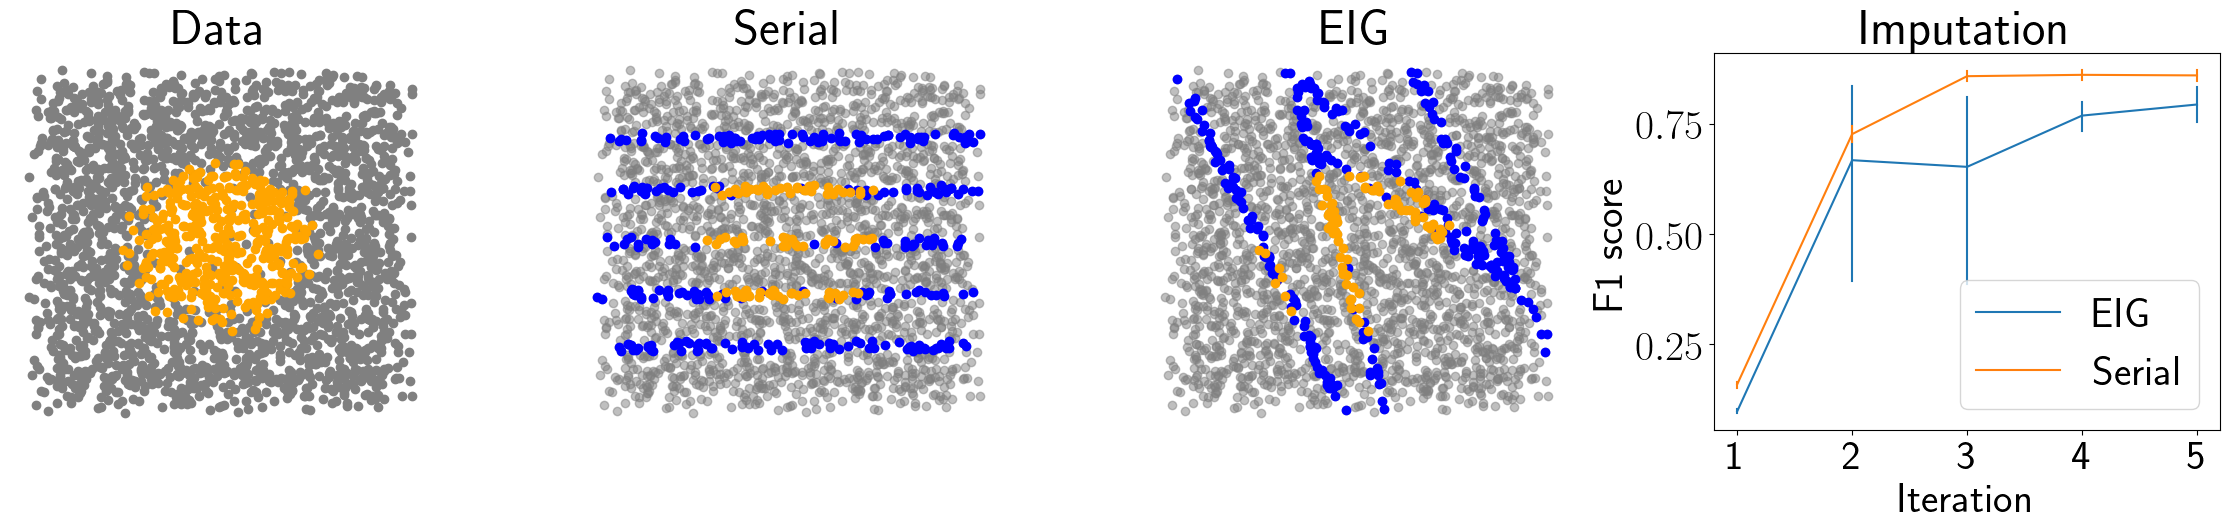

In [11]:

plt.close()
fig, axs = plt.subplots(
    1, 4, figsize=(23, 6), gridspec_kw={"width_ratios": [1, 1, 1, 1.2]}
)


## Plot data
plt.sca(axs[0])
for c in [0, 1]:
    curr_idx = onp.where(Y == c)[0]
    plt.scatter(
        X[curr_idx, 0], X[curr_idx, 1], label="Healthy" if c == 0 else "Tumor",
        c="gray" if c == 0 else "orange"
    )
plt.title("Data")
plt.axis("off")

plt.sca(axs[1])
observed_idx = onp.array(observed_idx)

plt.scatter(X[:, 0], X[:, 1], color="gray", alpha=0.5)

for c in [0, 1]:
    curr_idx = onp.where(Y[observed_idx_naive] == c)[0]
    plt.scatter(
        X[observed_idx_naive][curr_idx, 0],
        X[observed_idx_naive][curr_idx, 1],
        label=None if c == 0 else "ROI",
        c="blue" if c == 0 else "orange"
    )

plt.title("Serial")
plt.axis("off")

plt.sca(axs[2])
plt.scatter(X[:, 0], X[:, 1], color="gray", alpha=0.5)

for c in [0, 1]:
    curr_idx = onp.where(Y[observed_idx] == c)[0]
    plt.scatter(
        X[observed_idx][curr_idx, 0],
        X[observed_idx][curr_idx, 1],
        label="Healthy" if c == 0 else "Tumor",
        c="blue" if c == 0 else "orange"
    )

plt.title("EIG")
plt.axis("off")
# plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))



# plt.figure(figsize=(7, 5))
plt.sca(axs[3])

plt.title("Imputation")
# plt.plot(onp.arange(n_experimental_iters) + 1, accuracies, label="EIG")
# plt.plot(onp.arange(n_experimental_iters) + 1, accuracies_naive, label="Serial")
sns.lineplot(data=pd.melt(pd.DataFrame(overall_accuracies)), x="variable", y="value", err_style='bars', label="EIG") #, n_boot=100)
sns.lineplot(data=pd.melt(pd.DataFrame(overall_accuracies_naive)), x="variable", y="value", err_style='bars', label="Serial",) # n_boot=100) #, errorbar=('ci', 95))
plt.xlabel("Iteration")
plt.ylabel("F1 score")
# plt.ylim([0, 1])
plt.xticks(onp.arange(n_experimental_iters), labels=onp.arange(n_experimental_iters) + 1)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend()
plt.tight_layout()
plt.savefig("./out/border_finding_slicing.png")
plt.show()
plt.close()